# Machine Failure Prediction

## Libraries Import

In [353]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import plot_tree
from imblearn.combine import SMOTEENN
import numpy as np
import time

## Dataset Import

In [354]:
df = pd.read_csv('predictive_maintenance.csv')

## EDA

Effettuiamo ora l'analisi del dataset:

In [355]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [356]:
df.shape

(10000, 10)

In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [358]:
df['Target'] = df['Target'] ^ 1
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,1,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,1,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,1,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,1,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,1,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,1,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,1,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,1,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,1,No Failure


Le feature presenti sono le seguenti:
- **UDI** : Unique Device Identifier, ovvero un identificatore dell'istanza, univoco per ogni riga del dataset.
- **Product ID** : Identificatore del prodotto, univoco per ogni prodotto.
- **Type** : Feature categorica che indica la qualità del prodotto; assume valori discreti nel range [L, M, H], dove L='low Quality', M='Medium Quality', H='High Quality'.
- **Air Temperature** : Temperatura dell'aria in Kelvin (K), che potrebbe essere un parametro rilevante per il processo di produzione, indicando potenzialmente le condizioni ambientali o le impostazioni delle macchine.
- **Process Temperature** : Questa caratteristica si riferisce alla temperatura di processo in Kelvin (K). Può essere un parametro critico nel processo di produzione, che influisce sulla qualità del prodotto e sul funzionamento della macchina.
- **Rotational Speed** : Questa caratteristica rappresenta la velocità di rotazione delle macchine, che viene calcolata in base alla potenza e include un rumore normalmente distribuito. È un parametro essenziale per comprendere il funzionamento della macchina ed è espresso in rotazioni per minuto (rpm).
- **Torque** : Questa caratteristica indica il momento della forza, applicata dalle macchine durante il processo di produzione; è l'equivalente rotazionale del concetto fisico di forza ed è espresso in Newton per metri (Nm).
- **Tool Wear** : La caratteristica rappresenta lo stato di usura dell'utensile in termini di minuti di utilizzo ed è associata alle varianti di qualità (H/M/L). Suggerisce che gli utensili sono utilizzati insieme alle macchine durante il processo di produzione.
- **Target** : Questa è la variabile target del dataset, che rappresenta se la macchina possa avere un guasto oppure no. Questa è una variabile binaria, dove 0 indica che la macchina si è guastata e 1 indica che la macchina non si è guastata.
- **Failure Type** : Questa etichetta indica se la macchina si è guastata e, se si, quale guasto ha avuto. Ciò suggerisce che il set di dati include informazioni sui guasti delle macchine e che il set di dati può includere diversi tipi di macchine con diverse modalità di guasto.

Il dataset è composto da 10000 righe.

Verifichiamo che il dataset non contenga ne valori nulli o Nan, ne duplicati:

In [359]:
df.duplicated().sum()

0

In [360]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [361]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Per le nostre analisi non ci servono le colonne contenenti gli identificatori univoci delle macchine. 

In [362]:
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)
df.rename(columns={"Air temperature [K]":"Air Temperature", "Process temperature [K]":"Process Temperature", "Rotational speed [rpm]":"Rotational Speed", "Torque [Nm]":"Torque", "Tool wear [min]":"Tool Wear"}, inplace=True)

In [363]:
df.head()

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,1,No Failure
1,L,298.2,308.7,1408,46.3,3,1,No Failure
2,L,298.1,308.5,1498,49.4,5,1,No Failure
3,L,298.2,308.6,1433,39.5,7,1,No Failure
4,L,298.2,308.7,1408,40.0,9,1,No Failure


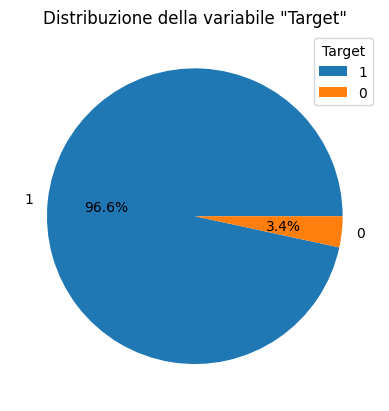

In [364]:
target = df["Target"].value_counts()

plt.pie(target, labels=["1", "0"], autopct='%1.1f%%')
plt.legend(title="Target")
plt.title("Distribuzione della variabile \"Target\"")
plt.show()

Vediamo come il dataset risulti essere sbilanciato in favore della classe 1, ovvero la classe che indica che la macchina non si è guastata. Sarà quindi necessario effettuare in seguito un ribilanciamento di esso.

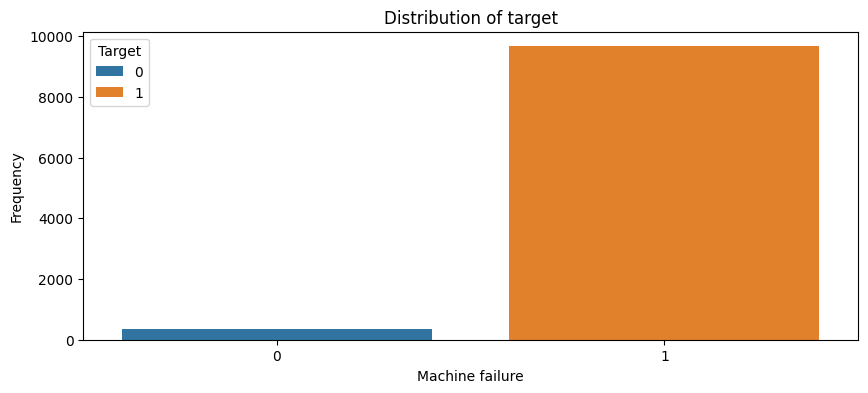

In [365]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Target', data=df, hue='Target')
plt.title("Distribution of target")
plt.xlabel("Machine failure")
plt.ylabel("Frequency")
plt.show()

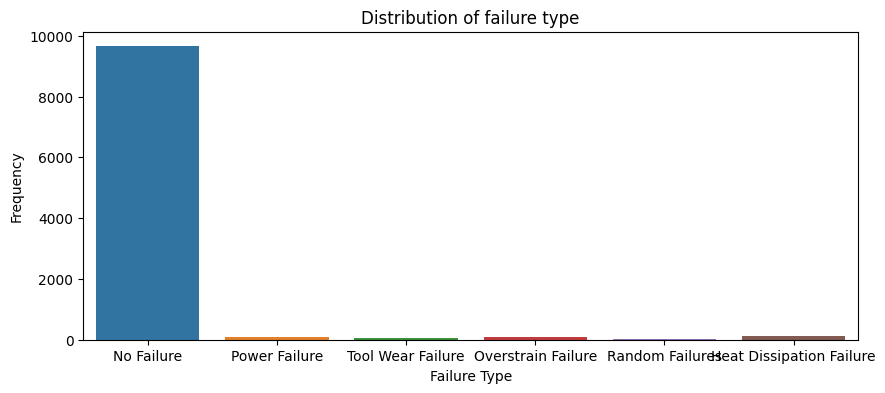

In [366]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Failure Type', data=df, hue='Failure Type')
plt.title("Distribution of failure type")
plt.xlabel("Failure Type")
plt.ylabel("Frequency")
plt.show()

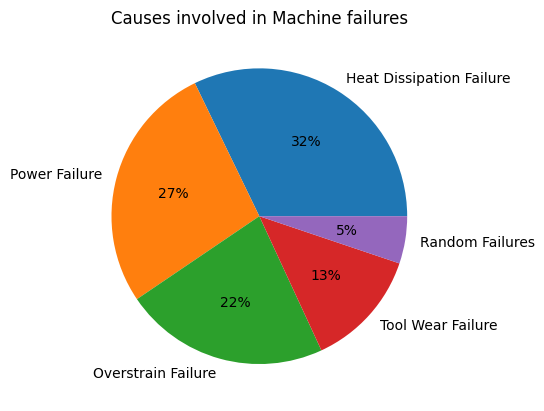

In [367]:
# Seleziona le righe dove 'Failure Type' è diverso da 'No Failure'
df_fail = df[df['Failure Type'] != 'No Failure']

# Calcola la percentuale di ogni tipo di guasto
df_fail_percentage = 100 * df_fail['Failure Type'].value_counts() / len(df_fail)

# Crea il grafico a torta
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.values, labels=df_fail_percentage.index,
        colors=sns.color_palette('tab10')[0:len(df_fail_percentage)], autopct='%.0f%%')
plt.show()

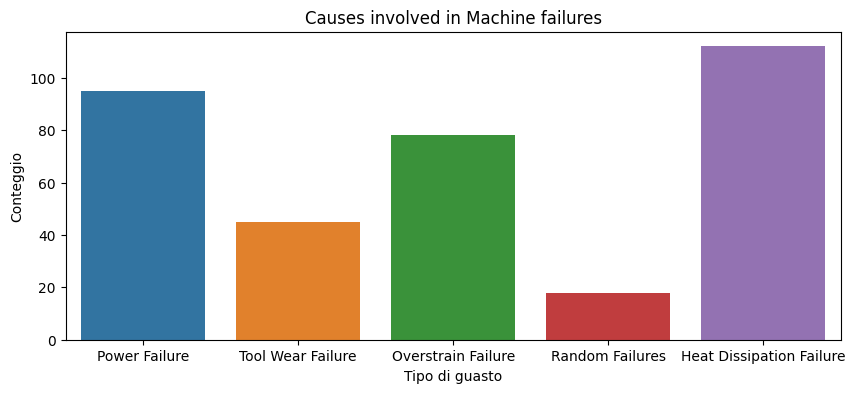

In [368]:
# Crea il countplot
plt.figure(figsize=(10,4))
sns.countplot( x='Failure Type', data=df_fail, hue='Failure Type')
plt.title('Causes involved in Machine failures')
plt.xlabel('Tipo di guasto')
plt.ylabel('Conteggio')
plt.show()

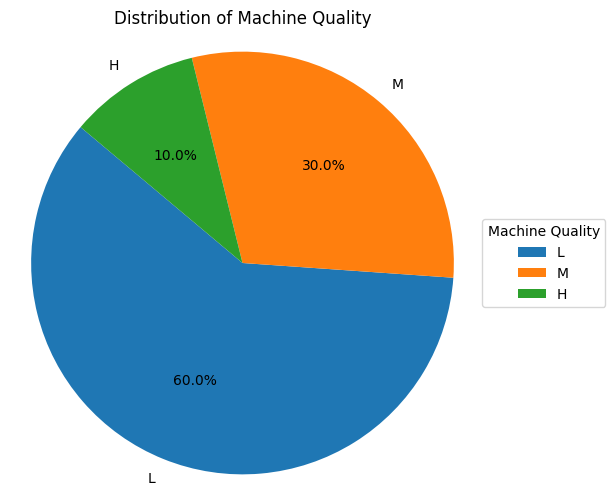

In [369]:
# Extracting the unique machine qualities and their counts
machine_qualities = df['Type'].value_counts()
labels = machine_qualities.index
counts = machine_qualities.values

# Creating the pie chart with more descriptive labels and a legend
plt.figure(figsize=(6, 6))  # Adjusting figure size for better readability
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Machine Quality')
plt.legend(labels, title="Machine Quality", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

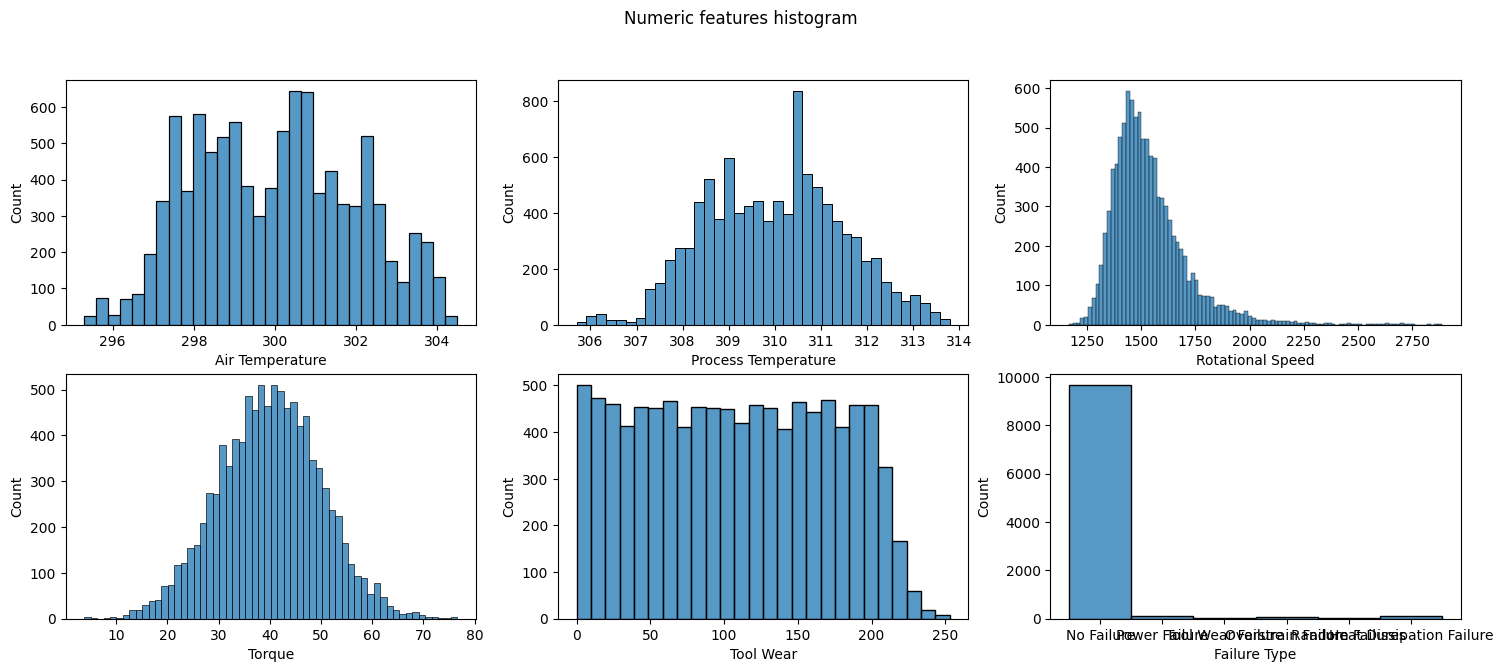

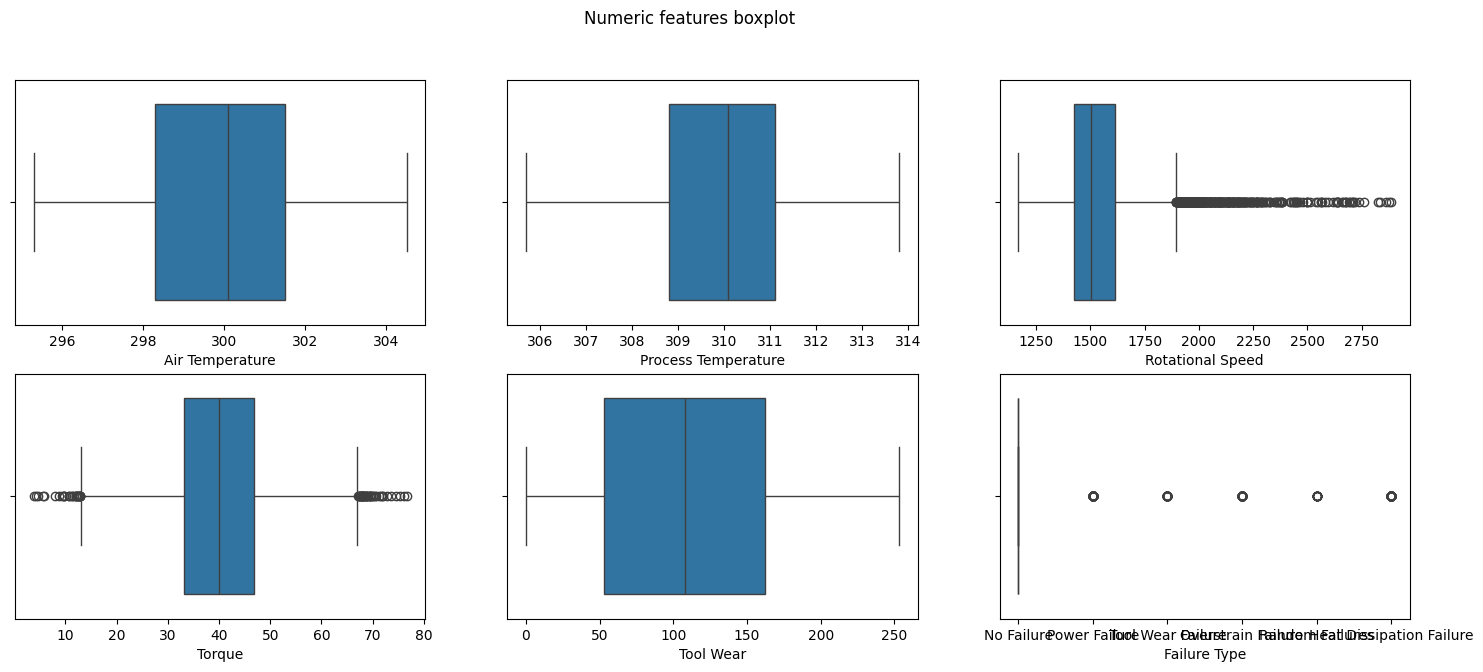

In [370]:
num_features = [feature for feature in df.drop(['Target', 'Type'], axis=1)]
# Histograms of numeric features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axes[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

# boxplot of numeric features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axes[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

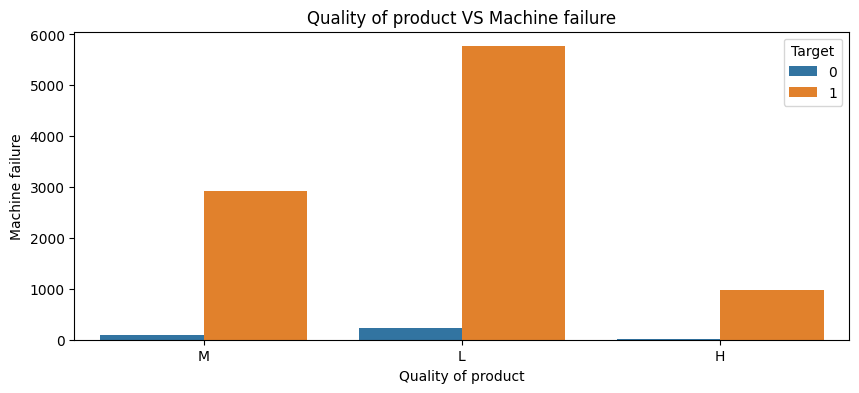

In [371]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Type', hue='Target')
plt.title('Quality of product VS Machine failure')
plt.xlabel('Quality of product')
plt.ylabel('Machine failure')
plt.show()

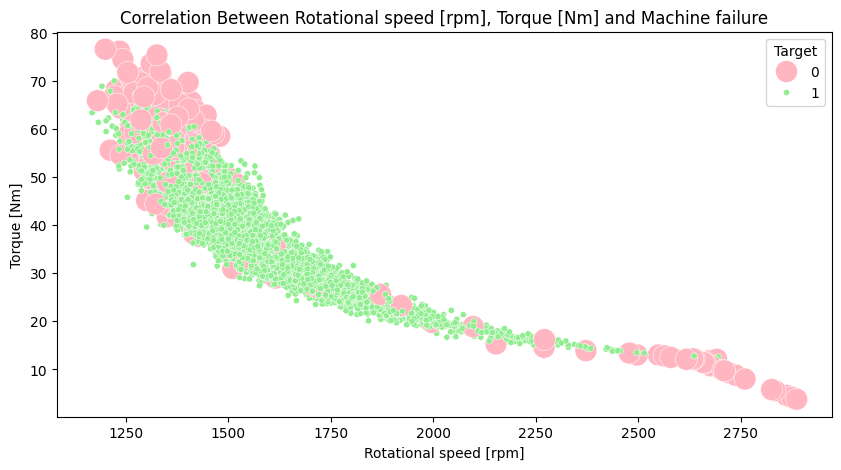

In [372]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Rotational Speed', y='Torque', hue='Target', palette=['lightpink', 'lightgreen'], data=df, size='Target', sizes=(20, 250))
plt.title('Correlation Between Rotational speed [rpm], Torque [Nm] and Machine failure')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.show()

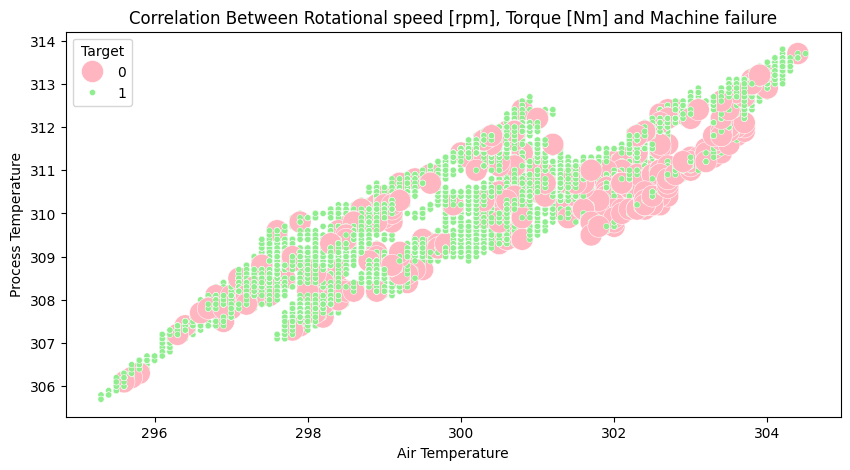

In [373]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Air Temperature', y='Process Temperature', hue='Target', palette=['lightpink', 'lightgreen'], data=df, size='Target', sizes=(20, 250))
plt.title('Correlation Between Rotational speed [rpm], Torque [Nm] and Machine failure')
plt.xlabel('Air Temperature')
plt.ylabel('Process Temperature')
plt.show()

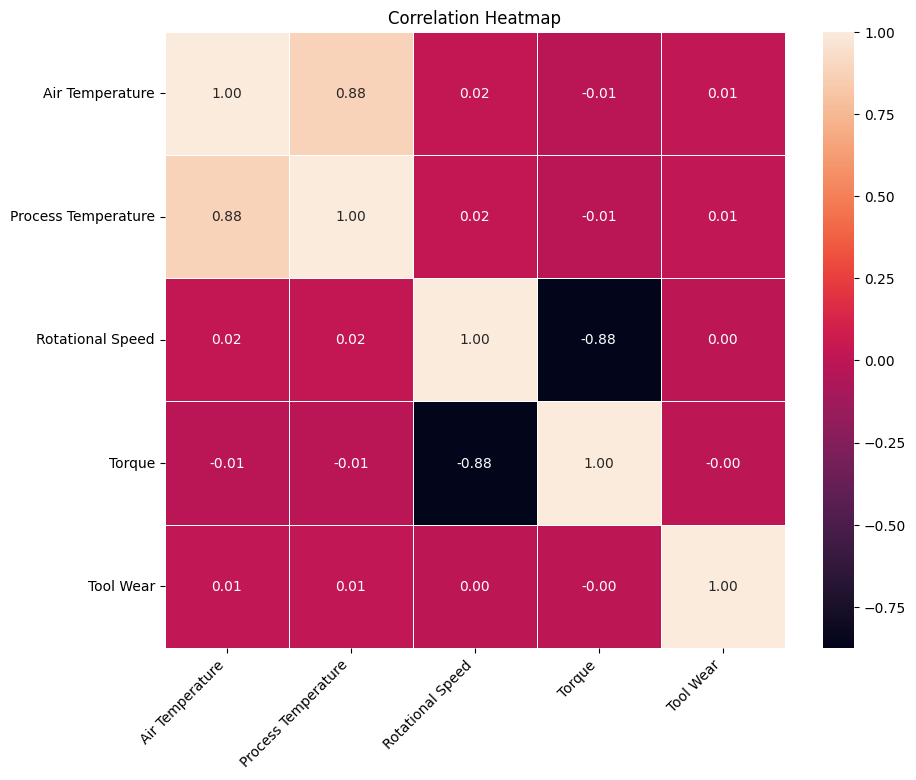

In [374]:
plt.figure(figsize=(10, 8))
heatmap_data = df[['Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear']]
correlation_matrix = heatmap_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

Vediamo dalla matrice di correlazione come le feature siano debolmente correlate tra loro, eccezione fatta per "Air Temperature" e "Process Temperature" che risultano avere una correlazione di 0.88, così come "Rotational Speed" e "Torque". Possiamo però considerare di introdurre 2 nuove feature rappresentanti una combinazione lineare delle due coppie di feature, ovvero:
- "Temperature Difference" = "Process Temperature" - "Air Temperature"
- "Power" = "a" * "Rotational Speed" * "Torque", con a = 0.104719755

In [375]:
df['Temperature Difference']= df['Process Temperature'] - df['Air Temperature']
df['Power'] = df['Torque'] * df['Rotational Speed'] * 0.104719755

In [376]:
df.head()

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target,Failure Type,Temperature Difference,Power
0,M,298.1,308.6,1551,42.8,0,1,No Failure,10.5,6951.590552
1,L,298.2,308.7,1408,46.3,3,1,No Failure,10.5,6826.722716
2,L,298.1,308.5,1498,49.4,5,1,No Failure,10.4,7749.387534
3,L,298.2,308.6,1433,39.5,7,1,No Failure,10.4,5927.504652
4,L,298.2,308.7,1408,40.0,9,1,No Failure,10.5,5897.816602


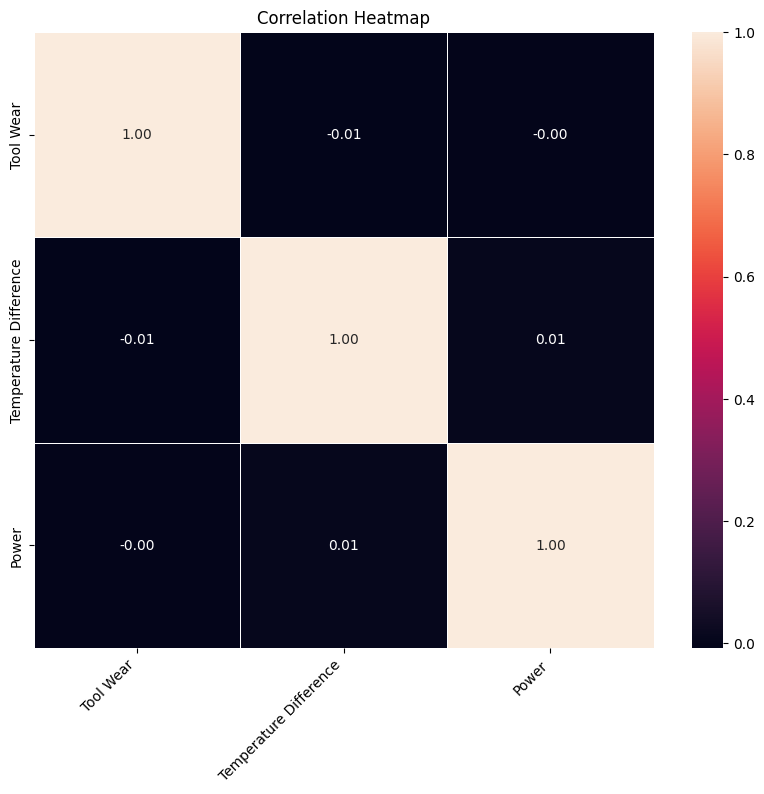

In [377]:
plt.figure(figsize=(10, 8))
heatmap_data = df[['Tool Wear', 'Temperature Difference', 'Power']]
correlation_matrix = heatmap_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

Salviamo quindi il dataset appena modificato:

In [378]:
df.to_csv("dataset.csv", index=False)

## Preparazione dei dati per Predizione Binaria

In [379]:
df = pd.read_csv("dataset.csv")
df = df.drop('Failure Type', axis=1)

Come prima cosa andiamo ad usare un Encoder alla feature 'Type' per trasformarla in variabile numerica:

In [380]:
df['Type'].unique()

array(['M', 'L', 'H'], dtype=object)

In [381]:
ordinal_feat=[['M'],
              ['L'],
              ['H']
              ]
order = ['L', 'M', 'H']

# Inizializza l'OrdinalEncoder
encoder = OrdinalEncoder(categories= [order])

# Adatta e trasforma i dati con l'OrdinalEncoder
encoded_data = encoder.fit_transform(ordinal_feat)

# Stampa i dati codificati
print(encoded_data)

[[1.]
 [0.]
 [2.]]


Andiamo ad effettuare la mappatura delle etichette per allinearle con i valori nel dataset:

In [382]:
mappatura_etichette = {
    ordinal_feat[0][0]: encoded_data[0][0],
    ordinal_feat[1][0]: encoded_data[1][0],
    ordinal_feat[2][0]: encoded_data[2][0]
}
df = df.applymap(lambda x: mappatura_etichette[x] if x in mappatura_etichette else x)
df['Type'] = df['Type'].astype(int)
df.head()

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target,Temperature Difference,Power
0,1,298.1,308.6,1551,42.8,0,1,10.5,6951.590552
1,0,298.2,308.7,1408,46.3,3,1,10.5,6826.722716
2,0,298.1,308.5,1498,49.4,5,1,10.4,7749.387534
3,0,298.2,308.6,1433,39.5,7,1,10.4,5927.504652
4,0,298.2,308.7,1408,40.0,9,1,10.5,5897.816602


Dividiamo il dataset in train e test:

In [383]:
y = df['Target']
X = df.drop('Target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Andiamo ora ad effettuare il resampling del nostro training set. Per farlo useremo il modello SMOTEENN, modello che combina le tecniche di oversampling e di undersampling utilizzando SMOTE e Edited Nearest Neighbour (ENN)"

In [384]:
print("Prima del resampling:")
print(y_train.value_counts())

print("\n")

smenn = SMOTEENN(random_state=2)
X_train, y_train = smenn.fit_resample(X_train, y_train)

print("Dopo il resampling:")
print(y_train.value_counts())

Prima del resampling:
Target
1    7722
0     278
Name: count, dtype: int64


Dopo il resampling:
Target
0    7086
1    6641
Name: count, dtype: int64


Scaliamo i dati:

In [385]:
features_to_scale = ['Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear', 'Temperature Difference', 'Power']

scaler = StandardScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

I modelli saranno allenati con 2 diverse configurazioni dei dati di train, ovvero:
- Con le feature originali, ovvero 'Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear' e 'Type'
- Con le feature create, ovvero 'Temperature Difference', 'Power', 'Tool Wear' e 'Type'

In [386]:
X_train_original = X_train.drop(['Temperature Difference', 'Power'], axis=1)
X_test_original = X_test.drop(['Temperature Difference', 'Power'], axis=1)

selected_feature = ['Type', 'Tool Wear', 'Temperature Difference', 'Power']
X_train_modified = X_train[selected_feature]
X_test_modified = X_test[selected_feature]

## Addestramento dei Modelli

Definiamo prima di tutto una funzione che raccoglie tutte le principali metriche di valutazione che andremo ad utilizare per i modelli che saranno allenati:

In [387]:
def prediction_evaluation(y_test, y_pred):

    accuracy = accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test,y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_wg = precision_score(y_test, y_pred, average='weighted')
    recall_wg = recall_score(y_test, y_pred, average='weighted')
    f1_wg = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", bal_acc)
    print("MCC: ", mcc)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)
    print("Precision weighted: ", precision_wg)
    print("Recall weighted: ", recall_wg)
    print("F1 weighted: ", f1_wg)
    print("ROC AUC: ", roc_auc)
     # Estrazione dei valori dalla matrice di confusione
    TP, FP, FN, TN = conf_matrix.ravel()

    # Calcolo della specificità
    specificity = TN / (TN + FP)
    print("Specificità:", specificity)

    # calcolo la precision negativa
    print("Precision negativa: ", TN/(TN+FN))

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.title('Confusion Matrix')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)


    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

### Binary DecisionTree


I Decision Tree sono modelli di apprendimento automatico utilizzati sia per problemi di classificazione che di regressione. Operano dividendo ripetutamente il dataset in sottoinsiemi omogenei in base alle caratteristiche dei dati, fino a quando non viene raggiunta una condizione di stop predefinita. Due caratteristiche principali degli alberi decisionali sono la versatilità e la semplicità.
Andiamo quindi ad addestrare un modello di Decision Tree:

Accuracy:  0.9365
Balanced Accuracy:  0.856107170334548
MCC:  0.451435422197109
Precision:  0.9923913043478261
Recall:  0.9417225373904075
F1:  0.9663932257210903
Precision weighted:  0.9710827445652174
Recall weighted:  0.9365
F1 weighted:  0.9498910830153301
ROC AUC:  0.856107170334548
Specificità: 0.9923913043478261
Precision negativa:  0.9417225373904075


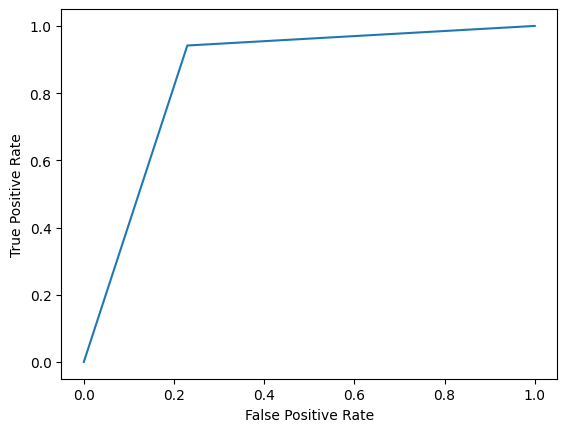

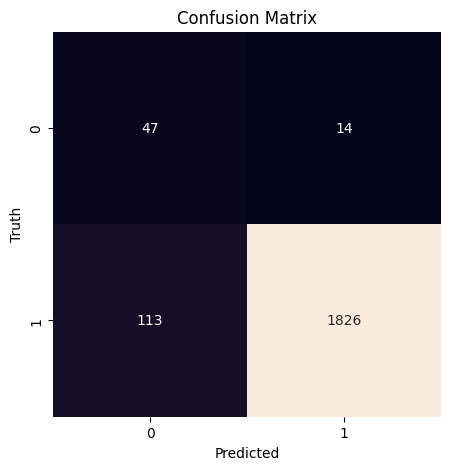

In [388]:
# Crea un'istanza del classificatore
clf = DecisionTreeClassifier(criterion="gini")

# Addestra il modello
clf.fit(X_train, y_train)

# Fai delle previsioni sul set di test
y_pred = clf.predict(X_test)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

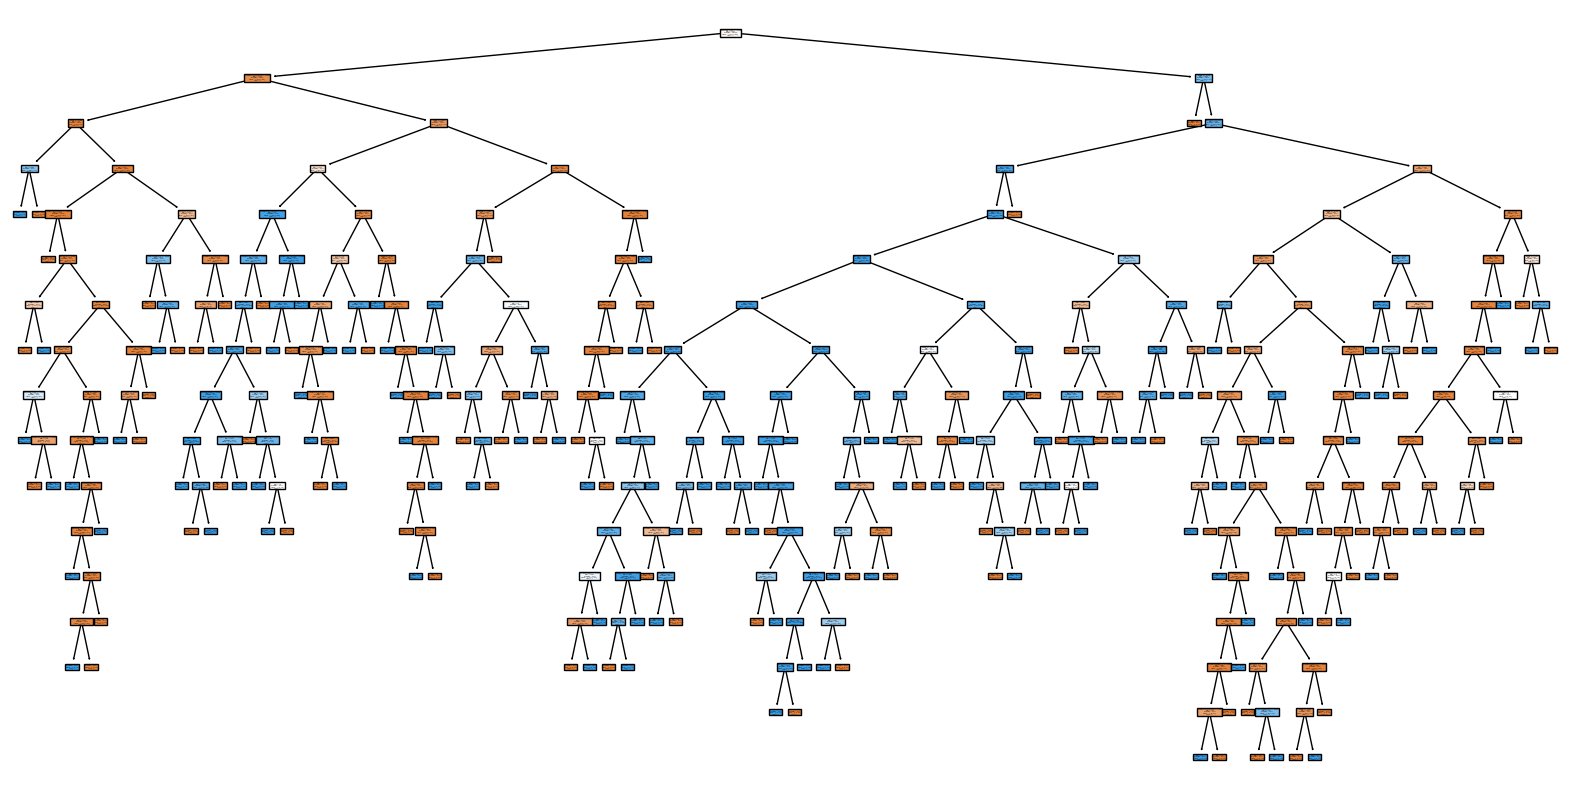

In [389]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['0','1'], proportion=True)
plt.show()

In [390]:
path=clf.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [391]:
# Train a series of decision trees with different alpha values
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train, y_train)
    pruned_models.append(pruned_model)

# Find the model with the best accuracy on test data
best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model
# Model Accuracy after pruning
accuracy_after_pruning = best_pruned_model.score(X_test, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)

Accuracy after pruning: 0.9395


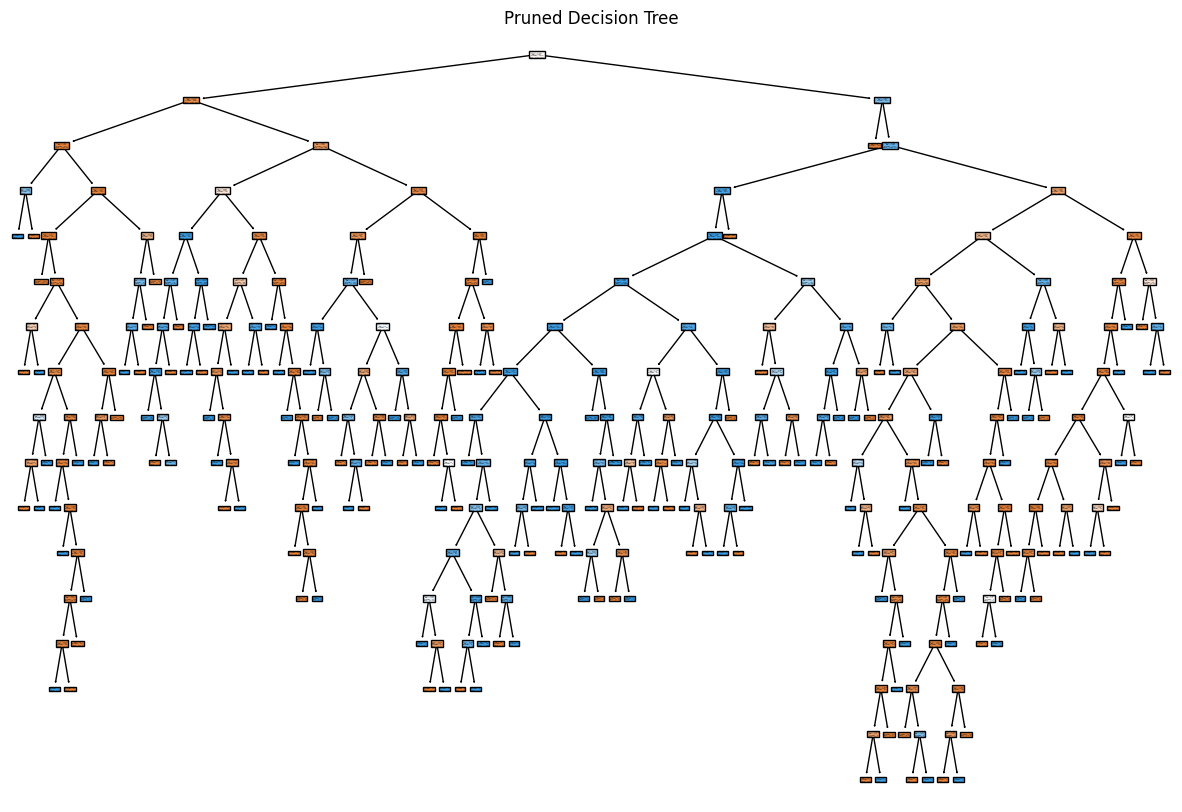

In [392]:
# Plot pruned tree
plt.figure(figsize=(15, 10))
plot_tree(best_pruned_model, filled=True)
plt.title("Pruned Decision Tree")
plt.show()

Usiamo come primo dataset quello originale:

Accuracy:  0.9375
Balanced Accuracy:  0.8328063307941393
MCC:  0.4319193086776045
Precision:  0.9908008658008658
Recall:  0.9443011861784425
F1:  0.9669923422233959
Precision weighted:  0.9694103867623605
Recall weighted:  0.9375
F1 weighted:  0.9501000147527185
ROC AUC:  0.8328063307941392
Specificità: 0.9908008658008658
Precision negativa:  0.9443011861784425


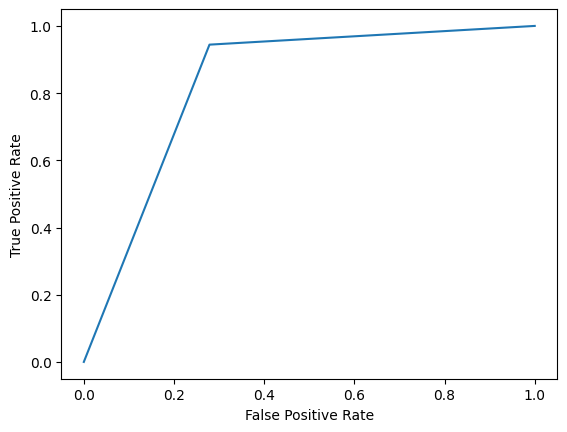

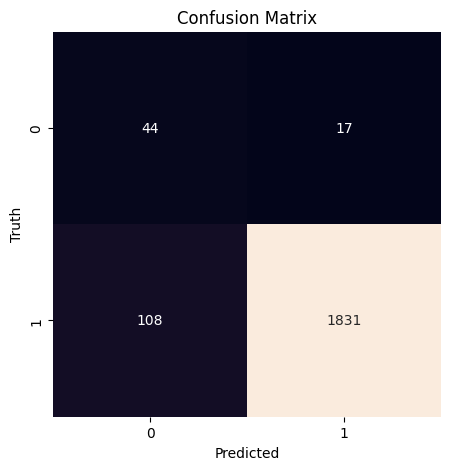

In [393]:
# Crea un'istanza del classificatore
clf = DecisionTreeClassifier(criterion="gini")

# Addestra il modello
clf.fit(X_train_original, y_train)

# Fai delle previsioni sul set di test
y_pred = clf.predict(X_test_original)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

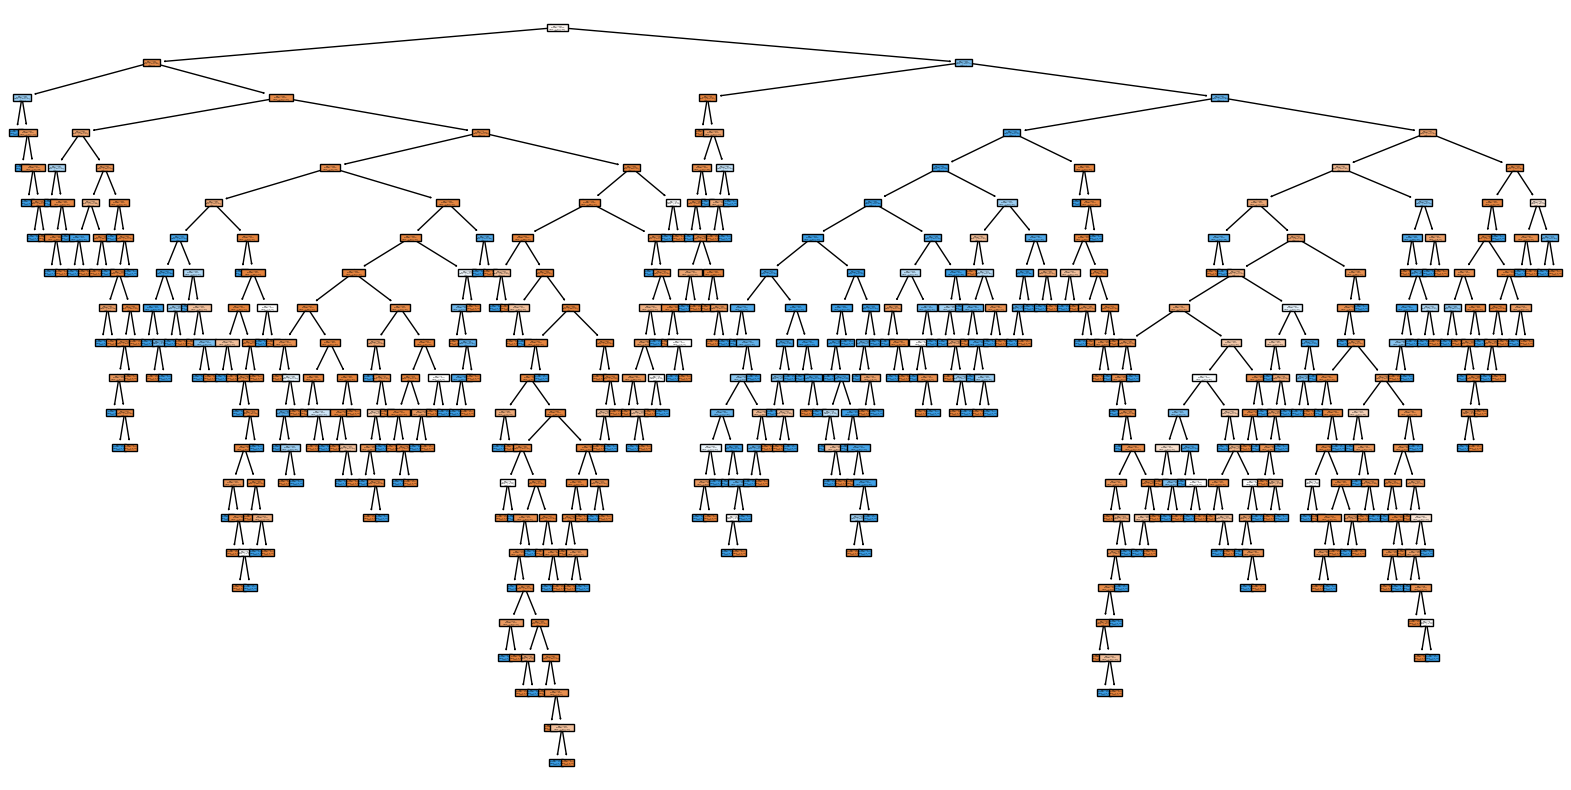

In [394]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train_original.columns, class_names=['0','1'], proportion=True)
plt.show()

#### Fine Tuning


Il pruning dell'albero è una tecnica di Machine Learning utilizzata per ottimizzare i modelli di albero di decisione riducendo l'overfitting e migliorando la generalizzazione a nuovi dati. Per il nostro caso utilizzeremo la tecninca di post-pruning.
Il post-pruning comporta la rimozione di rami o nodi per migliorare la capacità del modello di generalizzare. In particolare verrà applicato il metodo CPP (Cost-Complexity Pruning), metodo che assegna un valore a ciascun sottoalbero principalmente in base alla sua accuratezza e complessità, quindi seleziona il sottoalbero con il costo più basso.

In [395]:
path=clf.cost_complexity_pruning_path(X_train_original, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [396]:
# Train a series of decision trees with different alpha values
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train_original, y_train)
    pruned_models.append(pruned_model)

# Find the model with the best accuracy on test data
best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test_original, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model
# Model Accuracy after pruning
accuracy_after_pruning = best_pruned_model.score(X_test_original, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)

Accuracy after pruning: 0.9405


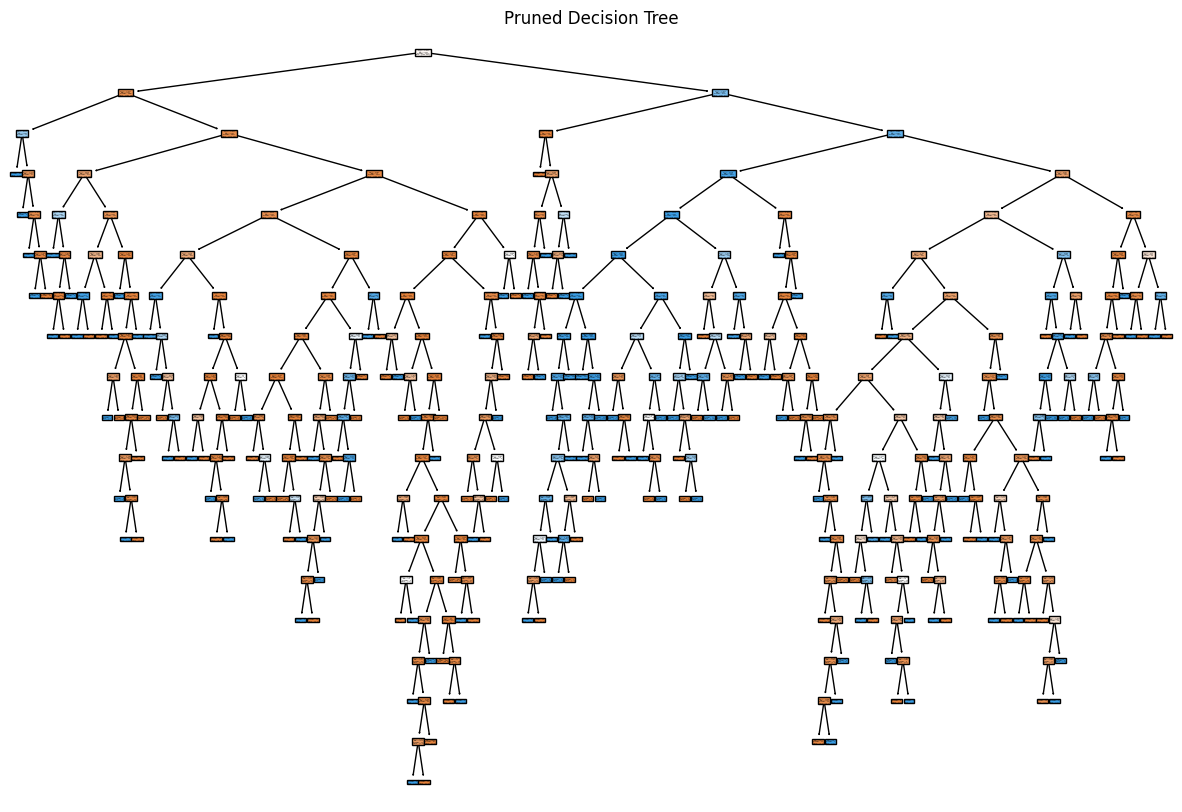

In [397]:
# Plot pruned tree
plt.figure(figsize=(15, 10))
plot_tree(best_pruned_model, filled=True)
plt.title("Pruned Decision Tree")
plt.show()

Alleniamo ora un nuovo modello con il dataset in cui abbiamo aggiunto le nuove feature:

Accuracy:  0.9255
Balanced Accuracy:  0.8186787172701833
MCC:  0.38887665048043174
Precision:  0.9901423877327492
Recall:  0.9324394017534812
F1:  0.9604249667994689
Precision weighted:  0.9674804012287395
Recall weighted:  0.9255
F1 weighted:  0.9422937074397447
ROC AUC:  0.8186787172701833
Specificità: 0.9901423877327492
Precision negativa:  0.9324394017534812


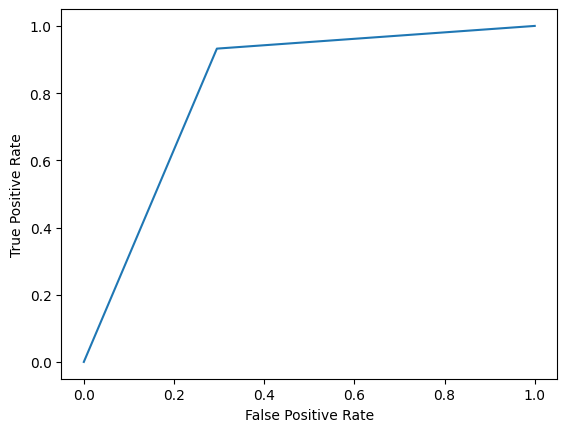

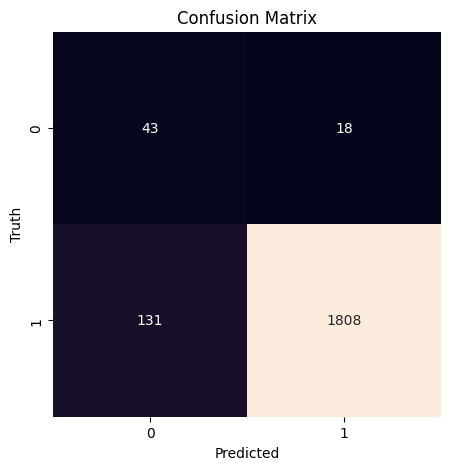

In [398]:
# Crea un'istanza del classificatore
clf = DecisionTreeClassifier(criterion="gini")

# Addestra il modello
clf.fit(X_train_modified, y_train)

# Fai delle previsioni sul set di test
y_pred = clf.predict(X_test_modified)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

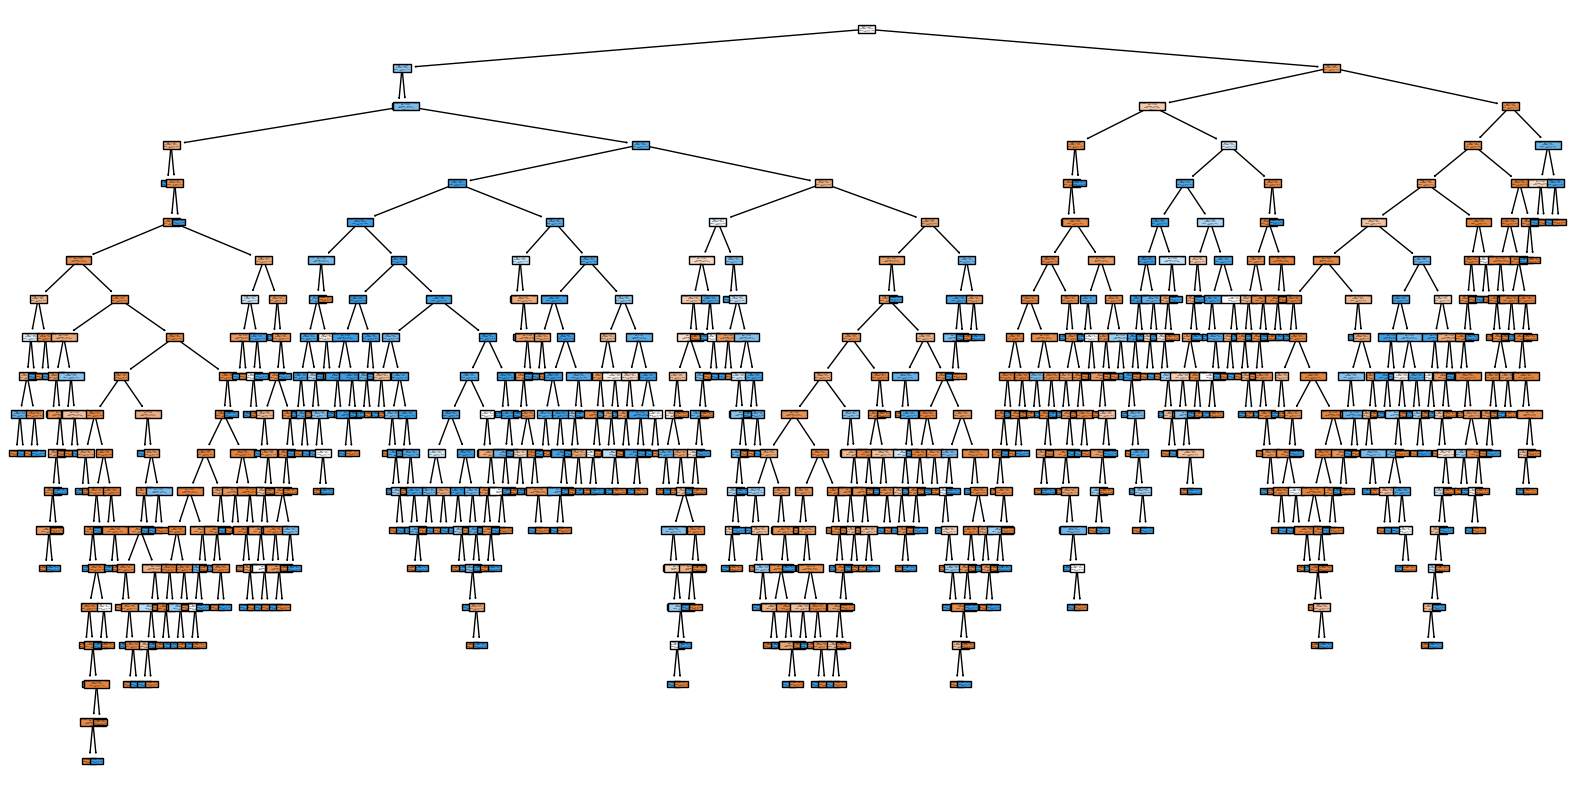

In [399]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train_modified.columns, class_names=['0','1'], proportion=True)
plt.show()

#### Fine Tuning

In [400]:
path=clf.cost_complexity_pruning_path(X_train_modified, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [401]:
# Train a series of decision trees with different alpha values
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train_modified, y_train)
    pruned_models.append(pruned_model)

# Find the model with the best accuracy on test data
best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test_modified, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model
# Model Accuracy after pruning
accuracy_after_pruning = best_pruned_model.score(X_test_modified, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)

Accuracy after pruning: 0.933


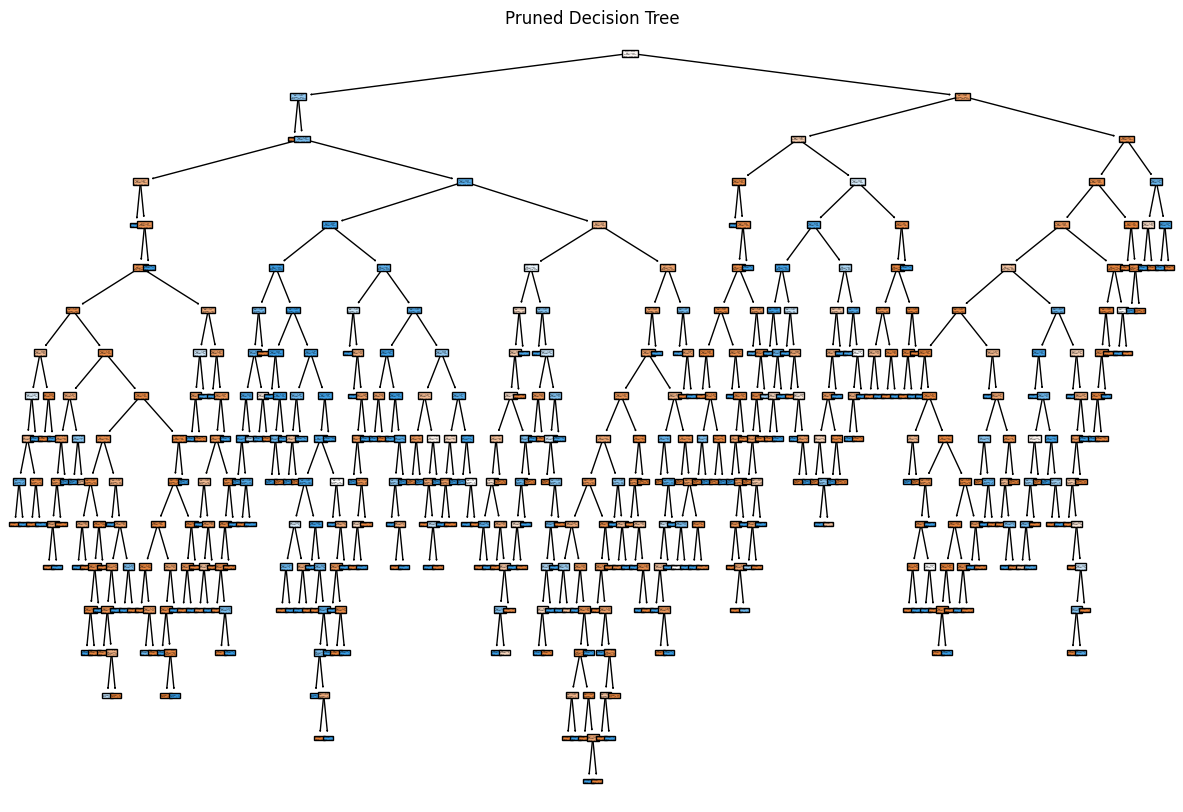

In [402]:
# Plot pruned tree
plt.figure(figsize=(15, 10))
plot_tree(best_pruned_model, filled=True)
plt.title("Pruned Decision Tree")
plt.show()

### Binary SVM

Le SVM (Support Vector Machines) sono un algoritmo di apprendimento supervisionato utilizzato sia per problemi di classificazione che di regressione. Le SVM sono potenti strumenti di classificazione che si distinguono per la loro capacità di trovare iperpiani di decisione ottimali che massimizzano il margine tra le classi e per la loro flessibilità nell'affrontare problemi complessi tramite il kernel trick.

Accuracy:  0.912
Balanced Accuracy:  0.8672883605711919
MCC:  0.40780509105569207
Precision:  0.9938375350140056
Recall:  0.9149045899948427
F1:  0.9527389903329753
Precision weighted:  0.9706185134518923
Recall weighted:  0.912
F1 weighted:  0.9347311757655007
ROC AUC:  0.8672883605711919
Specificità: 0.9938375350140056
Precision negativa:  0.9149045899948427


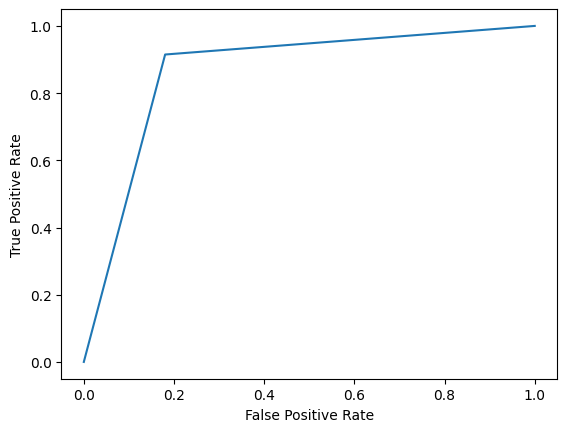

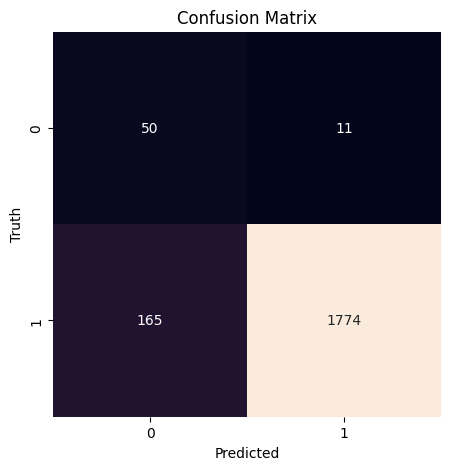

In [403]:
# Crea un'istanza del classificatore
svm = SVC()

# Addestra il modello
svm.fit(X_train, y_train)

# Fai delle previsioni sul set di test
y_pred = svm.predict(X_test)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

In [404]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   1.3s
[CV] END ....................C=0.1, gamma=0.1, 

KeyboardInterrupt: 

Accuracy:  0.9425
Balanced Accuracy:  0.8115684102841586
MCC:  0.4256423457079071
Precision:  0.9892703862660944
Recall:  0.9510056730273336
F1:  0.9697607152248225
ROC AUC:  0.8115684102841587
Specificità: 0.9892703862660944
Precision negativa:  0.9510056730273336


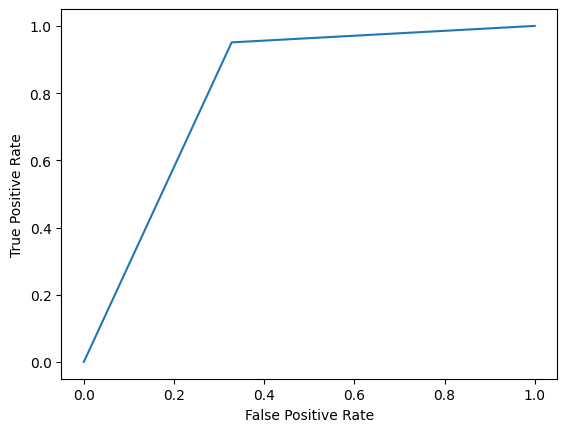

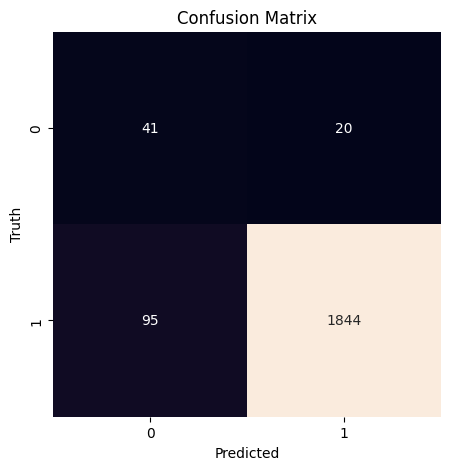

In [ ]:
# Crea un'istanza del classificatore
svm = SVC(**grid.best_params_)

# Addestra il modello
svm.fit(X_train, y_train)

# Fai delle previsioni sul set di test
y_pred = svm.predict(X_test)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

Alleniamo ora il modello con il dataset originale:

Accuracy:  0.9025
Balanced Accuracy:  0.8703277843065971
MCC:  0.394788799249049
Precision:  0.9943310657596371
Recall:  0.9045899948427024
F1:  0.9473399945989738
ROC AUC:  0.8703277843065972
Specificità: 0.9943310657596371
Precision negativa:  0.9045899948427024


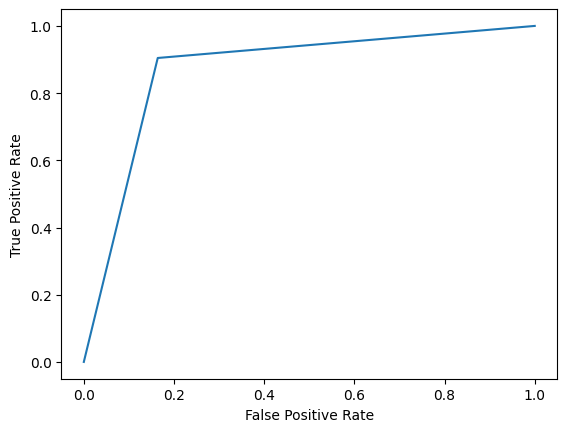

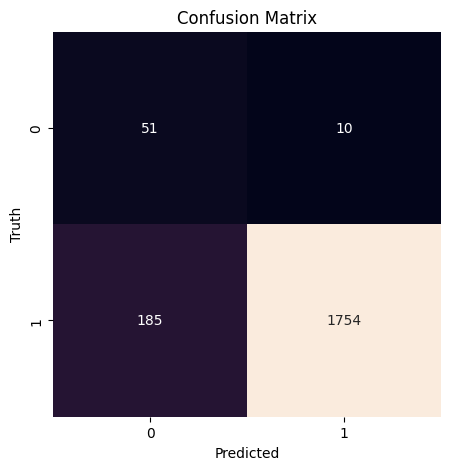

In [ ]:
# Crea un'istanza del classificatore
svm = SVC()

# Addestra il modello
svm.fit(X_train_original, y_train)

# Fai delle previsioni sul set di test
y_pred = svm.predict(X_test_original)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

#### Fine Tuning


Il fine tuning di un modello SVM può essere fatto regolando i suoi parametri per trovare la loro combinazione migliore; in particolare analizzeremo i seguenti parametri:
- C: Questo parametro controlla il compromesso tra ottenere il margine più ampio possibile e minimizzare il tasso di classificazione errata.
- gamma: Questo parametro controlla quanto influisce un singolo esempio di addestramento.
- kernel: Questo parametro controlla il tipo di iperpiano utilizzato per separare i dati.

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_original, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   1.5s
[CV] END ....................C=0.1, gamma=0.1, 

Accuracy:  0.943
Balanced Accuracy:  0.8277039880283059
MCC:  0.4431849027966638
Precision:  0.9903277807630306
Recall:  0.9504899432697267
F1:  0.9700000000000001
ROC AUC:  0.8277039880283059
Specificità: 0.9903277807630306
Precision negativa:  0.9504899432697267


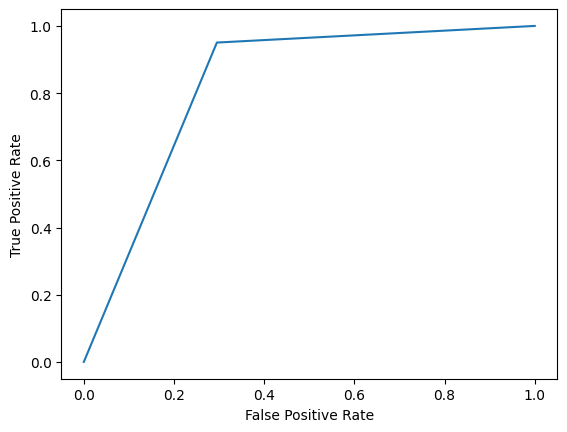

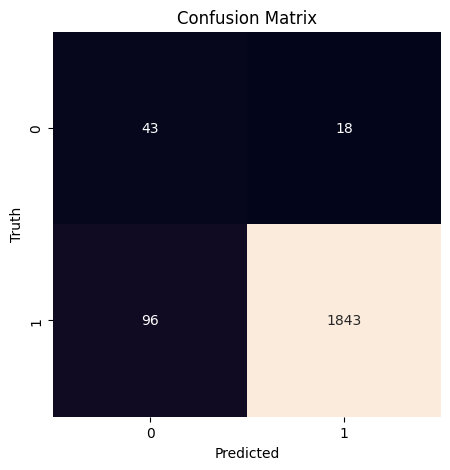

In [ ]:
# Crea un'istanza del classificatore
svm = SVC(**grid.best_params_)

# Addestra il modello
svm.fit(X_train_original, y_train)

# Fai delle previsioni sul set di test
y_pred = svm.predict(X_test_original)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

Usiamo ora il dataset modificato:

Accuracy:  0.8755
Balanced Accuracy:  0.8722807937165515
MCC:  0.3615690683999667
Precision:  0.9953106682297772
Recall:  0.8757091284167097
F1:  0.9316872427983539
ROC AUC:  0.8722807937165517
Specificità: 0.9953106682297772
Precision negativa:  0.8757091284167097


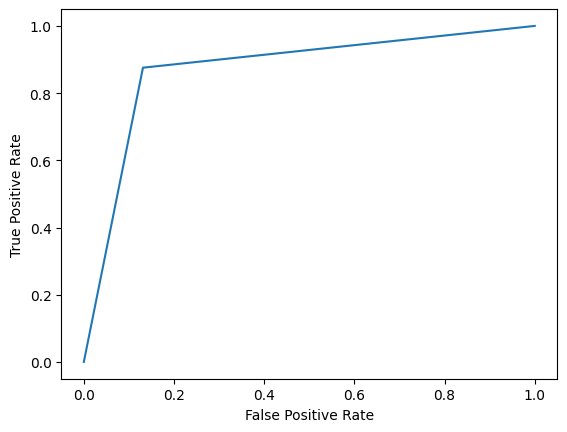

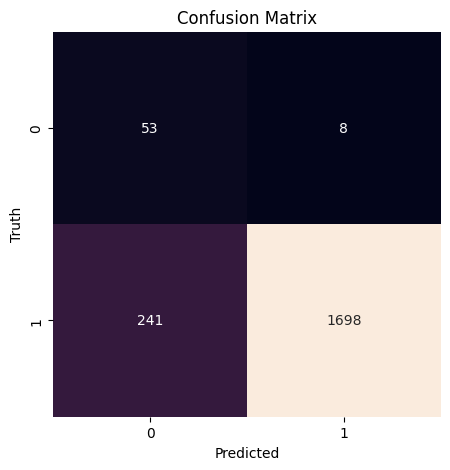

In [ ]:
# Crea un'istanza del classificatore
svm = SVC()

# Addestra il modello
svm.fit(X_train_modified, y_train)

# Fai delle previsioni sul set di test
y_pred = svm.predict(X_test_modified)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

#### Fine Tuning

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_modified, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.6s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   2.3s
[CV] END ....................C=0.1, gamma=0.1, 

Accuracy:  0.899
Balanced Accuracy:  0.8447061608569568
MCC:  0.3668027086741049
Precision:  0.9926262053318208
Recall:  0.9025270758122743
F1:  0.9454349000540249
ROC AUC:  0.8447061608569568
Specificità: 0.9926262053318208
Precision negativa:  0.9025270758122743


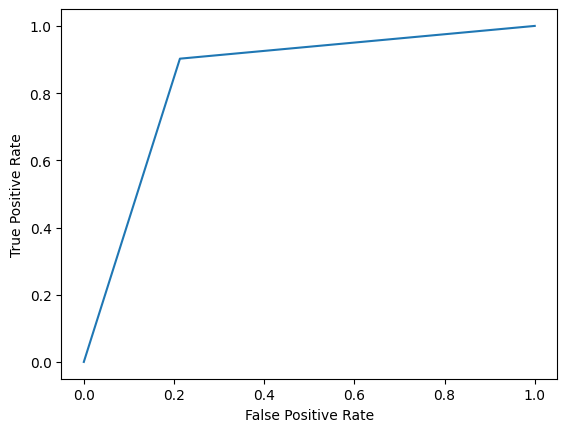

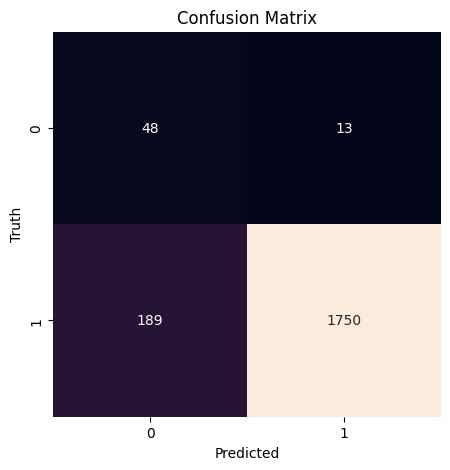

In [ ]:
# Crea un'istanza del classificatore
svm = SVC(**grid.best_params_)

# Addestra il modello
svm.fit(X_train_modified, y_train)

# Fai delle previsioni sul set di test
y_pred = svm.predict(X_test_modified)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

## Preparazione dei dati per Predizione Multivariata

In [ ]:
df = pd.read_csv("dataset.csv")
df = df.drop('Target', axis=1)
df = df.rename(columns={'Failure Type': 'Target'})

In [ ]:
mask = df['Target'] != 'No Failure'
df = df[mask]

Dividiamo il dataset in train e test:

In [ ]:
y = df['Target']
X = df.drop('Target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_test

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Temperature Difference,Power
5615,M,303.0,312.2,1257,71.3,122,9.2,9385.413794
4081,L,302.0,310.4,1336,58.2,110,8.4,8142.505494
8195,L,299.4,310.8,1376,53.9,215,11.4,7766.687237
6178,L,301.1,310.9,1282,67.9,10,9.8,9115.624289
4409,M,302.4,310.1,1358,54.6,61,7.7,7764.634730
...,...,...,...,...,...,...,...,...
3695,L,302.2,311.3,1530,37.3,207,9.1,5976.251698
4495,L,302.6,310.4,1359,57.2,67,7.8,8140.369211
4527,M,302.4,310.5,1372,45.7,144,8.1,6565.970526
4620,L,303.1,311.3,1336,52.6,172,8.2,7359.034175


Come prima cosa andiamo ad usare un Encoder alla feature 'Type' per trasformarla in variabile numerica:

In [ ]:
X_test['Type'].unique()

array(['M', 'L', 'H'], dtype=object)

In [ ]:
ordinal_feat=[['M'],
              ['L'],
              ['H']
              ]
order = ['L', 'M', 'H']

# Inizializza l'OrdinalEncoder
encoder = OrdinalEncoder(categories= [order])

# Adatta e trasforma i dati con l'OrdinalEncoder
encoded_data = encoder.fit_transform(ordinal_feat)

# Stampa i dati codificati
print(encoded_data)

[[1.]
 [0.]
 [2.]]


In questo caso non è necessario effettuare la mappatura delle etichette, in quanto già allineate.

In [ ]:
mappatura_etichette = {
    ordinal_feat[0][0]: encoded_data[0][0],
    ordinal_feat[1][0]: encoded_data[1][0],
    ordinal_feat[2][0]: encoded_data[2][0]
}

X_train = X_train.applymap(lambda x: mappatura_etichette[x] if x in mappatura_etichette else x)
X_train['Type'] = X_train['Type'].astype(int)
X_train.head()

X_test = X_test.applymap(lambda x: mappatura_etichette[x] if x in mappatura_etichette else x)
X_test['Type'] = X_test['Type'].astype(int)
X_test.head()

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Temperature Difference,Power
5615,1,303.0,312.2,1257,71.3,122,9.2,9385.413794
4081,0,302.0,310.4,1336,58.2,110,8.4,8142.505494
8195,0,299.4,310.8,1376,53.9,215,11.4,7766.687237
6178,0,301.1,310.9,1282,67.9,10,9.8,9115.624289
4409,1,302.4,310.1,1358,54.6,61,7.7,7764.634730


In [ ]:
y_train

4469           Tool Wear Failure
3019          Overstrain Failure
3579               Power Failure
586           Overstrain Failure
2494          Overstrain Failure
                  ...           
4558    Heat Dissipation Failure
2671           Tool Wear Failure
4002               Power Failure
6255          Overstrain Failure
3867               Power Failure
Name: Target, Length: 278, dtype: object

In [ ]:
y_test

5615               Power Failure
4081    Heat Dissipation Failure
8195          Overstrain Failure
6178               Power Failure
4409    Heat Dissipation Failure
                  ...           
3695           Tool Wear Failure
4495    Heat Dissipation Failure
4527    Heat Dissipation Failure
4620    Heat Dissipation Failure
8846           Tool Wear Failure
Name: Target, Length: 70, dtype: object

Ora è necessario invece effettuare l'encoding del target usando un LabelEncoder:

In [ ]:
encoder = LabelEncoder()

# Addestra il LabelEncoder e trasforma le etichette di addestramento
y_train_temp = encoder.fit_transform(y_train)

# Trasforma le etichette di test
y_test_temp = encoder.transform(y_test)

y_train = pd.Series(y_train_temp, index=y_train.index, name=y_train.name)
y_test = pd.Series(y_test_temp, index=y_test.index, name=y_test.name)

## Allenamento dei Modelli


In [ ]:
def prediction_evaluation(y_test, y_pred):

    accuracy = accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test,y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", bal_acc)
    print("MCC: ", mcc)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    plt.figure(figsize=(10, 10))
    plt.title('Confusion Matrix')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)

    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

### MultiClass DecisionTree

Accuracy:  0.9571428571428572
Balanced Accuracy:  0.8625
MCC:  0.9417324381294665
Precision:  0.953409090909091
Recall:  0.8625
F1:  0.8911821705426355


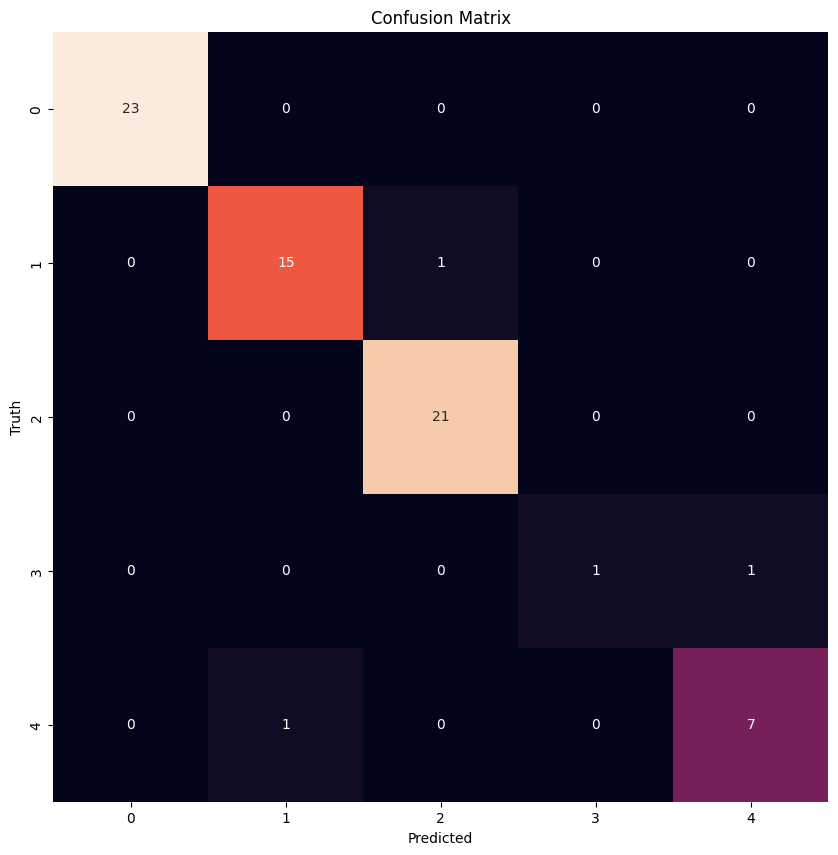

In [ ]:
# Crea un'istanza del classificatore
clf = DecisionTreeClassifier(criterion="gini")

# Addestra il modello
clf.fit(X_train, y_train)

# Fai delle previsioni sul set di test
y_pred = clf.predict(X_test)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

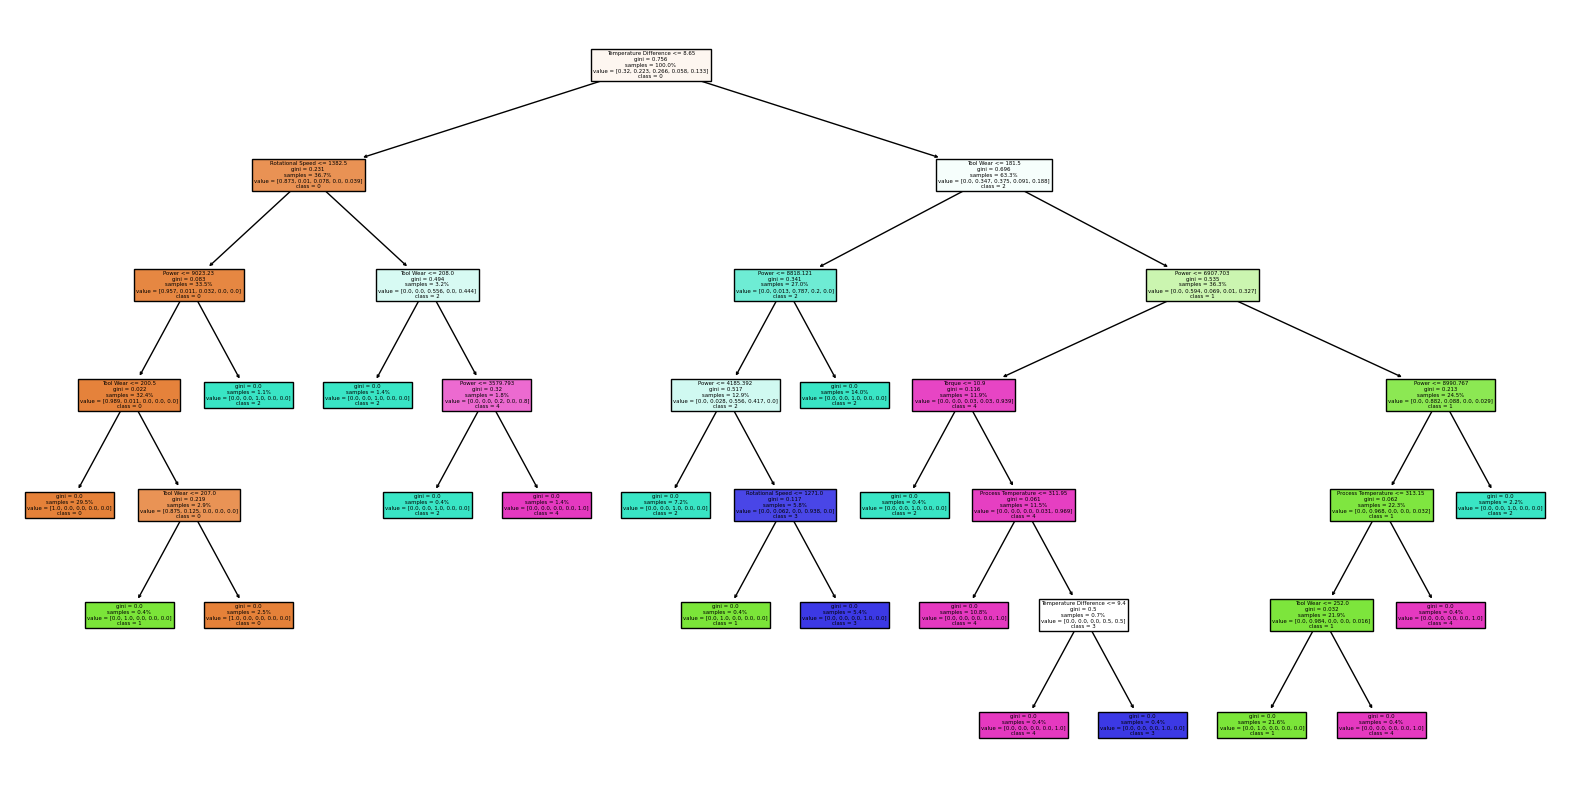

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['0','1', '2', '3', '4'], proportion=True)
plt.show()

#### Fine Tuning

In [ ]:
path=clf.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
# Train a series of decision trees with different alpha values
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train, y_train)
    pruned_models.append(pruned_model)

# Find the model with the best accuracy on test data
best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model
# Model Accuracy after pruning
accuracy_after_pruning = best_pruned_model.score(X_test, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)

Accuracy after pruning: 0.9571428571428572


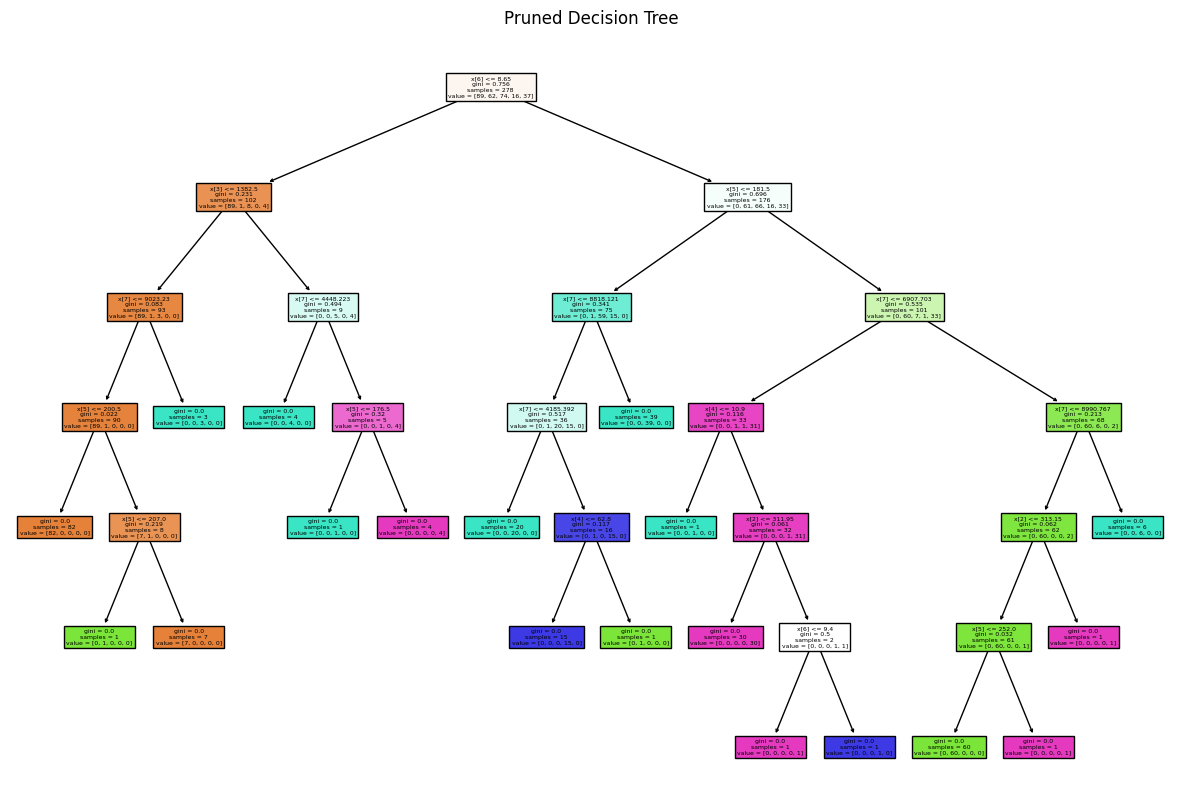

In [ ]:
# Plot pruned tree
plt.figure(figsize=(15, 10))
plot_tree(best_pruned_model, filled=True)
plt.title("Pruned Decision Tree")
plt.show()